### Importing Data

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from random import *
from math import log
import json

%matplotlib inline

In [4]:

with open('dataset/good_reviews.json') as f:
    good_reviews = [json.loads(line) for line in f]
with open('dataset/business.json') as f:
    business_data = [json.loads(line) for line in f]
with open('dataset/user.json') as f:
    user_data = [json.loads(line) for line in f]



In [8]:
good_reviews = good_reviews[0]

In [10]:
sorted_user_reviews = sorted(good_reviews, key = lambda x: x['user_id'])

## Creating the train, valid, and test sets

For matrix factorization, we faced several unique issues:

* Matrix Sparsity: Our data was incredibly sparse. Originally, our matrix had <5% non zero values. However, single-value decomposition doesn't work on sparse matrices. Thus, we had to reduce our set of restaurant reviews significantly, to only include restaurants and user with over 100 reviews. We also used alternating least squares to find the latent factor vectors, as opposed to SVD.

* Runtime: The process of learning the latent was incredibly time intensive. Thus, we limited our model to 4 latent factors. 

* Size of model: Our train set included 1252 users and 3484 restaurants, Thus, we only computed latent factors for 1252 users and 3484 items.

We also made sure that the same users were represented in the train, valid, and test sets and in the same proportion. 

In [12]:
train_set = []
valid_set = []
test_set = []
for i,x in enumerate(sorted_user_reviews[:100000]):
    short = {k: x[k] for k in ['business_id', 'stars', 'user_id']}
    if i % 3 == 0:
        train_set.append(short)
    elif i % 3 == 1:
        valid_set.append(short)  
    else:
        test_set.append(short)

In [13]:
train_df = pd.DataFrame(train_set)
valid_df = pd.DataFrame(valid_set)
test_df = pd.DataFrame(test_set)

# ALS Matrix Factorization with 4 Factors

### Making the dataset more manageable

In [14]:
trimmed_train = train_df[:5000]
trimmed_train.shape

(5000, 3)

### Getting the user and item deviations

In [23]:
restaurant_data = [x for x in business_data if 'Restaurants' in x['categories']]

good_restaurants_info = [x for x in restaurant_data if x['review_count'] >= 100]
restaurant_dict = {x['business_id']: x['stars'] for x in restaurant_data}
good_user_info = [x for x in user_data if x['review_count'] >= 100]
user_dict = {x['user_id']: x['average_stars'] for x in good_user_info}

global_review_average = sum(trimmed_train['stars'].values)/len(trimmed_train)
user_global_average = sum(user_dict.values())/len(user_dict)
rest_global_average = sum(restaurant_dict.values())/len(restaurant_dict)
user_deviations = {x: user_dict[x] - user_global_average for x in user_dict}
restaurant_deviations = {x: restaurant_dict[x] - rest_global_average for x in restaurant_dict}

### Making the dictionaries

We wanted to create 2 dictionaries:
* ratings_by_restaurant_train_trimmed: This dictionary has key = restaurant and value = all the reviews given to the restaurant
* ratings_by_user_train_trimmed: This dictionary has key = user and value = all the reviews that the user has given

In [29]:
ratings_by_restaurant_train_trimmed = {}
ratings_by_user_train_trimmed = {}

for i in range(len(trimmed_train)):
    row = trimmed_train.iloc[i]
    bus_id = row[0]
    stars = row[1]
    user_id = row[2]
    if bus_id not in ratings_by_restaurant_train_trimmed:
        ratings_by_restaurant_train_trimmed[bus_id] = {user_id : stars}
    else:
        ratings_by_restaurant_train_trimmed[bus_id][user_id] = stars
        
    if user_id not in ratings_by_user_train_trimmed:
        ratings_by_user_train_trimmed[user_id] = {bus_id : stars}
    else:
        ratings_by_user_train_trimmed[user_id][bus_id] = stars
    

### Preparing for Alternating Least Squares

We create the random dummy vectors to initial our p and q vectors, set lambda the regularization parameter equal to 0.1, and decide our tuning vectors.

In [31]:
#create dummy vectors for p and q at start
import random
q_item = {}
p_user = {}
#just random
for r in ratings_by_restaurant_train_trimmed:
    q_item[r] = [randrange(1,10)/10 for _ in range(4)]
for u in ratings_by_user_train_trimmed:
    p_user[u] = [randrange(1,10)/10 for _ in range(4)]

In [32]:
tuning_vectors = []
for a in range(1,10):
    for b in range(1,10):
        for c in range(1,10):
            for d in range(1,10):
                tuning_vectors.append([a/10, b/10, c/10, d/10])

In [33]:
lmda = 0.1

### Defining tuning functions

In [38]:
def calculate_sum_user_4(tuning_vector, user):
    user_vector = tuning_vector
    uv_mag = np.linalg.norm(user_vector)
    summation = 0
    #iterate through restaurants that user has rated
    for restaurant in ratings_by_user_train_trimmed[user]:
        #get the restaurants vector
        item_vector = q_item[restaurant]
        rv_mag = np.linalg.norm(item_vector)
        term = np.dot(user_vector, item_vector) 
        #get the biases
        user_dev = user_deviations[user]
        item_dev = restaurant_deviations[restaurant]
        #follow the MLE equation
        error = (ratings_by_user_train_trimmed[user][restaurant] - global_review_average - term - user_dev - item_dev) ** 2 
        + lmda * (uv_mag **2 + rv_mag ** 2 + user_dev ** 2 + item_dev ** 2)
        summation += error
    return summation


def minimize_user_vectors_4():
    convergence = 0
    #iterate though all the the users
    for user in ratings_by_user_train_trimmed:
        #list of tuples (tuning vector, sum)
        tuning_sums = []
        #iterate though the vectors to find the best one for the user
        for tuning_vector in tuning_vectors:
            tuning_sum = calculate_sum_user_4(tuning_vector, user)
            tuning_sums.append((tuning_vector, tuning_sum))
        #get the vector with the lowest sum
        best = (min(tuning_sums, key = lambda x: x[1])[0])
        #get the difference between the current vector and the best vector
        difference = abs(best[0] - p_user[user][0]) + abs(best[1] - p_user[user][1])
        + abs(best[2] - q_item[item][2]) + abs(best[3] - q_item[item][3])
        #set vector to best
        p_user[user] = best
        #add the difference to the convergence
        convergence += difference
    return convergence
                     
                 

In [35]:
def calculate_sum_item_4(tuning_vector, item):
    item_vector = tuning_vector
    rv_mag = np.linalg.norm(item_vector)
    summation = 0
    for user in ratings_by_restaurant_train_trimmed[item]:
        user_vector = p_user[user]
        uv_mag = np.linalg.norm(user_vector)
        term = np.dot(item_vector, user_vector) 
        user_dev = user_deviations[user]
        item_dev = restaurant_deviations[item]
        error = (ratings_by_restaurant_train_trimmed[item][user] - global_review_average - user_dev - item_dev - term) ** 2 
        + lmda * (uv_mag **2 + rv_mag ** 2 + user_dev ** 2 + item_dev ** 2)
        #print ('error', error)
        summation += error
    return summation


def minimize_item_vectors_4():
    #print ('minimizing item vectors')
    convergence = 0
    #iterate though all the the users
    for item in ratings_by_restaurant_train_trimmed:
        #list with tuple (vector, corresponding sum)
        tuning_sums = []
        #iterate though the vectors to find the best one for the user
        for tuning_vector in tuning_vectors:
            tuning_sum = calculate_sum_item_4(tuning_vector, item)
            tuning_sums.append((tuning_vector, tuning_sum))
        best = (min(tuning_sums, key = lambda x: x[1])[0])
        #print ('best', best)
        #get the difference between the current vector and the best vector
        difference = abs(best[0] - q_item[item][0]) + abs(best[1] - q_item[item][1]) 
        + abs(best[2] - q_item[item][2]) + abs(best[3] - q_item[item][3])
        #set vector to best
        #print ('best',best)
        q_item[item] = best
        convergence += difference
        #print ('convergence value', convergence)
    return convergence
                     

            

In [39]:
def ALS_4():
    print ('minimizing user vectors')
    conv = minimize_user_vectors_4()
    print (conv)
    #whil vectors have not converged
    while conv > 10: 
        for _ in range(1000):
            print ('minimizing item vectors')
            conv = minimize_item_vectors_4()
            print (conv)
            print ('minimizing user vectors')
            conv = minimize_user_vectors_4()
            print (conv)
                
              

In [40]:
ALS_4()

minimizing user vectors
948.2000000000005
minimizing item vectors
2680.099999999998
minimizing user vectors
206.19999999999956
minimizing item vectors
359.6999999999987
minimizing user vectors
90.89999999999995
minimizing item vectors
196.79999999999959
minimizing user vectors
32.40000000000004
minimizing item vectors
144.0
minimizing user vectors
21.800000000000004
minimizing item vectors
86.80000000000001
minimizing user vectors
12.399999999999997
minimizing item vectors


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-cf41abbe0d88>", line 1, in <module>
    ALS_4()
  File "<ipython-input-39-7b846cbe4343>", line 8, in ALS_4
    conv = minimize_item_vectors_4()
  File "<ipython-input-35-4e7e92481872>", line 27, in minimize_item_vectors_4
    tuning_sum = calculate_sum_item_4(tuning_vector, item)
  File "<ipython-input-35-4e7e92481872>", line 3, in calculate_sum_item_4
    rv_mag = np.linalg.norm(item_vector)
  File "/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 2022, in norm
    def norm(x, ord=None, axis=None, keepdims=False):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1821, in showtraceback
    stb =

KeyboardInterrupt: 

Here are the final vectors after convergence:

In [284]:
list(p_user.items())[:10]

[('---1lKK3aKOuomHnwAkAow', [0.1, 0.1, 0.1, 0.1]),
 ('--2vR0DIsmQ6WfcSzKWigw', [0.1, 0.1, 0.1, 0.1]),
 ('--3WaS23LcIXtxyFULJHTA', [0.1, 0.1, 0.1, 0.1]),
 ('--4q8EyqThydQm-eKZpS-A', [0.9, 0.9, 0.9, 0.9]),
 ('--56mD0sm1eOogphi2FFLw', [0.9, 0.9, 0.9, 0.9]),
 ('--CIuK7sUpaNzalLAlHJKA', [0.1, 0.8, 0.9, 0.1]),
 ('--J3HPoNe-IJ0xE10Z_sDg', [0.1, 0.1, 0.1, 0.1]),
 ('--Qh8yKWAvIP4V4K8ZPfHA', [0.1, 0.8, 0.1, 0.1]),
 ('--RlSfc-QmcHFGHyX6aVjA', [0.1, 0.1, 0.1, 0.1]),
 ('--ZNfWKj1VyVElRx6-g1fg', [0.1, 0.1, 0.1, 0.1])]

In [285]:
list(q_item.items())[:10]

[('sZsJooAzpKqOvDysphkqpQ', [0.1, 0.1, 0.1, 0.1]),
 ('t6WY1IrohUecqNjd9bG42Q', [0.1, 0.3, 0.8, 0.2]),
 ('1JgaRBX0oiRsvEhHF3ZMjw', [0.1, 0.1, 0.1, 0.1]),
 ('2BbFeotL85cIaBjSq1SWiA', [0.1, 0.1, 0.1, 0.1]),
 ('5cbsjFtrntUAeUx51FaFTg', [0.1, 0.1, 0.1, 0.1]),
 ('eJKnymd0BywNPrJw1IuXVw', [0.1, 0.1, 0.1, 0.1]),
 ('Gdv3qhsDeQzZ2Ag-Tzq6vA', [0.1, 0.1, 0.1, 0.1]),
 ('vW65SNLam99SyOuVagNuvg', [0.1, 0.3, 0.1, 0.3]),
 ('nK7JeIqdBli3umEhBIh33g', [0.1, 0.1, 0.9, 0.1]),
 ('zt5S0bSsc8JAWalRMpSk6Q', [0.1, 0.1, 0.1, 0.1])]

## Validating to determine the best lambda


In [100]:
valid_businesses = [x['business_id'] for x in valid_set]
valid_users = [x['user_id'] for x in valid_set]

In [119]:
from collections import Counter
c = Counter()
c = Counter(valid_businesses)
d = Counter()
d = Counter(valid_users)
keep_business = [item for item in c if c[item] > 20 ]
keep_users = [item for item in d if d[item] > 20]

### Validating to determing the regularization parameter


We cut down on our valid set, keeping ~300 data points, in order to expedite the process of validation.

In [286]:
valid_trimmed = [x for x in valid_set if x['business_id'] in keep_business and x['user_id'] in keep_users]
valid_trimmed_df = pd.DataFrame(valid_trimmed)
valid_trimmed_df.shape


(306, 3)

In [121]:
valid_trimmed_df.sort_values(by = ['user_id']).head()

,business_id,stars,user_id
0,p3YqOYELqXtLyHz9T49p_w,2,-50XWnmQGqBgEI-9ANvLlg
1,3BCsAgo_1i4xMuTyLKMLRQ,3,-50XWnmQGqBgEI-9ANvLlg
2,wuQDMDlqM17jQNo0lYQZ7g,5,-50XWnmQGqBgEI-9ANvLlg
3,g8oxQ1Ji9mr9PMjhEfaWSg,4,-50XWnmQGqBgEI-9ANvLlg
4,9a3DrZvpYxVs3k_qwlCNSw,5,-RhRXVW9z9fs5zzxhFfnHg


Our code for cross validation is similar to our code above.

In [122]:
ratings_by_restaurant_valid = {}
ratings_by_user_valid = {}

for i in range(len(valid_trimmed_df)):
    row = valid_trimmed_df.iloc[i]
    bus_id = row[0]
    stars = row[1]
    user_id = row[2]
    if bus_id not in ratings_by_restaurant_valid:
        ratings_by_restaurant_valid[bus_id] = {user_id : stars}
    else:
        ratings_by_restaurant_valid[bus_id][user_id] = stars
        
    if user_id not in ratings_by_user_valid:
        ratings_by_user_valid[user_id] = {bus_id : stars}
    else:
        ratings_by_user_valid[user_id][bus_id] = stars
    

In [153]:
def calculate_sum_user_CV(tuning_vector, user, LAMBDA, q_item_CV, p_user_CV):
    user_vector = tuning_vector
    uv_mag = np.linalg.norm(user_vector)
    summation = 0
    for restaurant in ratings_by_user_valid[user]:
        item_vector = q_item_CV[restaurant]
        rv_mag = np.linalg.norm(item_vector)
        term = np.dot(user_vector, item_vector) 
        user_dev = user_deviations[user]
        item_dev = restaurant_deviations[restaurant]
        error = (ratings_by_user_valid[user][restaurant] - global_review_average - term - user_dev - item_dev) ** 2 
        + LAMBDA * (uv_mag **2 + rv_mag ** 2 + user_dev ** 2 + item_dev ** 2)
        summation += error
    return summation

def minimize_user_vectors_CV(LAMBDA, q_item_CV, p_user_CV):
    convergence = 0
    for user in ratings_by_user_valid:
        tuning_sums = []
        for tuning_vector in tuning_vectors:
            tuning_sum = calculate_sum_user_CV(tuning_vector, user, LAMBDA, q_item_CV, p_user_CV)
            tuning_sums.append((tuning_vector, tuning_sum))
        best = (min(tuning_sums, key = lambda x: x[1])[0])
        difference = abs(best[0] - p_user_CV[user][0]) + abs(best[1] - p_user_CV[user][1])
        + abs(best[2] - p_user_CV[user][2]) + abs(best[3] - p_user_CV[user][3])
        p_user_CV[user] = best
        convergence += difference
    return convergence

def calculate_sum_item_CV(tuning_vector, item, LAMBDA, q_item_CV, p_user_CV):
    item_vector = tuning_vector
    rv_mag = np.linalg.norm(item_vector)
    summation = 0
    for user in ratings_by_restaurant_valid[item]:
        user_vector = p_user_CV[user]
        uv_mag = np.linalg.norm(user_vector)
        term = np.dot(item_vector, user_vector) 
        user_dev = user_deviations[user]
        item_dev = restaurant_deviations[item]
        error = (ratings_by_restaurant_valid[item][user] - global_review_average - user_dev - item_dev - term) ** 2 
        + LAMBDA * (uv_mag **2 + rv_mag ** 2 + user_dev ** 2 + item_dev ** 2)
        summation += error
    return summation


def minimize_item_vectors_CV(LAMBDA, q_item_CV, p_user_CV):
    convergence = 0
    for item in ratings_by_restaurant_valid:
        tuning_sums = []
        for tuning_vector in tuning_vectors:
            tuning_sum = calculate_sum_item_CV(tuning_vector, item, LAMBDA, q_item_CV, p_user_CV)
            tuning_sums.append((tuning_vector, tuning_sum))
        best = (min(tuning_sums, key = lambda x: x[1])[0])
        difference = abs(best[0] - q_item_CV[item][0]) + abs(best[1] - q_item_CV[item][1]) 
        + abs(best[2] - q_item_CV[item][2]) + abs(best[3] - q_item_CV[item][3])
        q_item_CV[item] = best
        convergence += difference
    return convergence
                     
                 

In [208]:
def ALS_CV(q_item_CV, p_user_CV, LAMBDA):
    print ('optimizing item vectors')
    convergence = minimize_item_vectors_CV(LAMBDA, q_item_CV, p_user_CV)
    print (convergence)
    while convergence > 5:
        print ('optimizing user vectors')
        convergence = minimize_user_vectors_CV(LAMBDA, q_item_CV, p_user_CV)
        print (convergence)
        print ('optimizing item vectors')
        convergence = minimize_item_vectors_CV(LAMBDA, q_item_CV, p_user_CV)
        print (convergence)
    return q_item_CV, p_user_CV

def predict(p_user_CV, q_item_CV, user_id, business_id):
    user_dev = user_deviations[user_id]
    item_dev = restaurant_deviations[business_id]
    latent_term = np.dot(p_user_CV[user_id], q_item_CV[business_id]) 
    #print (latent_term)
    prediction = global_review_average + user_dev + item_dev + latent_term
    return int(round(prediction))

def score_CV(q_item_CV, p_user_CV, LAMBDA, df):
    predictions = []
    for j in range(len(df)):
        row = df.iloc[j]
        business_id = row[0]
        user_id = row[2]
        pred = predict(p_user_CV, q_item_CV, user_id, business_id)
        #print (pred)
        predictions.append(pred)
    print (predictions)
    actual = df['stars']
    df['validation_{}'.format(LAMBDA)] = predictions
    return metrics.accuracy_score(actual, predictions)
        
def validate(LAMBDA):
    q_item_CV = {}
    p_user_CV = {}
    for r in ratings_by_restaurant_valid:
        q_item_CV[r] = [randrange(1,10)/10 for _ in range(4)]
    for u in ratings_by_user_valid:
        p_user_CV[u] = [randrange(1,10)/10 for _ in range(4)]
    best_q_item, best_p_user = ALS_CV(q_item_CV, p_user_CV, LAMBDA)
    score = score_CV(best_q_item, best_p_user, LAMBDA, valid_trimmed_df)
    return score

def run_validation(LAMBDAS):
    validation_scores = {}
    for LAMBDA in LAMBDAS:
        print (LAMBDA)
        score = validate(LAMBDA)
        print ('score', score)
        validation_scores[LAMBDA] = score
    return validation_scores
        
        

In [210]:
LAMBDAS = [0.001, 0.01, 0.1, 1, 10]
run_validation(LAMBDAS)

0.001
optimizing item vectors
78.89999999999999
optimizing user vectors
84.80000000000003
optimizing item vectors
16.700000000000003
optimizing user vectors
9.0
optimizing item vectors
3.8000000000000007
[4, 5, 4, 4, 5, 4, 4, 3, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 5, 3, 5, 4, 4, 4, 4, 3, 4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4, 3, 3, 4, 4, 4, 5, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, 3, 5, 5, 5, 3, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 4, 3, 5, 5, 5, 4, 4, 5, 4, 5, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 4, 3, 4, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 5, 5, 3, 3, 4, 3, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 5, 4, 4, 3, 3, 5, 3, 4, 4, 4, 3, 4, 4, 5, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 3, 4, 5, 4, 5, 4, 3, 4, 3, 5, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 5, 

In [212]:
validation_scores = {0.001:0.59477124183, 0.01: 0.598039215686, 0.1: 0.598039215686,
                     1: 0.598039215686,10: 0.601307189542}

In [213]:
validation_scores

{0.001: 0.59477124183,
 0.01: 0.598039215686,
 0.1: 0.598039215686,
 1: 0.598039215686,
 10: 0.601307189542}

The best lambda according to our validation is 10. However, because ALS is extremely time-intensive, we were unable to retune our latent factors using the lambda.

In [294]:
def model_predict(user_id, business_id):
    user_dev = user_deviations[user_id]
    item_dev = restaurant_deviations[business_id]
    latent_term = 0
    if user_id in p_user:
        if business_id in q_item:
            latent_term = np.dot(p_user[user_id], q_item[business_id]) 
    prediction = global_review_average + user_dev + item_dev 
    latent = prediction + latent_term
    #print (prediction)
    return int(round(prediction)), int(round(latent))

def predict_all(df):
    predictions = []
    base_predictions = []
    for j in range(len(df)):
        row = df.iloc[j]
        business_id = row[0]
        user_id = row[2]
        pred, latent = model_predict(user_id, business_id)
        base_predictions.append(pred)
        predictions.append(latent)
    df['pred_base'] = base_predictions
    df['pred_latent'] = predictions
    base_score = metrics.accuracy_score(df['stars'], df['pred_base'])
    latent_score = metrics.accuracy_score(df['stars'], df['pred_latent'])
    return base_score, latent_score

## Evaluating and comparing the latent factors on the train and test sets

In [295]:
train_pred = pd.DataFrame(trimmed_train)
base, latent = predict_all(train_pred)
print ('The accuracy on the train set is {}'.format(base))
print ('The accuracy on the train set using latent factors is {}'.format(latent))

The accuracy on the train set is 0.4056
The accuracy on the train set using latent factors is 0.6136


We modified our test set to include (user, restaurant) reviews where both the user and restaurant had a latent factor associated it.

In [297]:
test_set_v2 = [x for x in test_set if x['business_id'] in q_item and x['user_id'] in p_user]
test_df_v2 = pd.DataFrame(test_set_v2)
base_test, latent_test = predict_all(test_df_v2)
print ('The accuracy on the test set is {}'.format(base_test))
print ('The accuracy on the test set using latent factors is {}'.format(latent_test))


The accuracy on the test set is 0.398324802233597
The accuracy on the test set using latent factors is 0.39599813866914846


Our latent factor model is much more fitted to the train set, resulting in a higher train accuracy but equal test accuracy. 

In [298]:
train_pred.head()

,business_id,stars,user_id,pred,pred_base,pred_latent
0,sZsJooAzpKqOvDysphkqpQ,5,---1lKK3aKOuomHnwAkAow,4,4,4
1,t6WY1IrohUecqNjd9bG42Q,4,---1lKK3aKOuomHnwAkAow,4,4,4
2,1JgaRBX0oiRsvEhHF3ZMjw,1,---1lKK3aKOuomHnwAkAow,4,4,4
3,2BbFeotL85cIaBjSq1SWiA,1,---1lKK3aKOuomHnwAkAow,3,3,3
4,5cbsjFtrntUAeUx51FaFTg,1,---1lKK3aKOuomHnwAkAow,3,3,3


In [299]:
pred_avg = []
pred_avg_latent = []
for i in [1, 2, 3, 4, 5]:
    pred_avg.append(train_pred[train_pred['stars'] == i]['pred_base'].mean())
    pred_avg_latent.append(train_pred[train_pred['stars'] == i]['pred_latent'].mean())

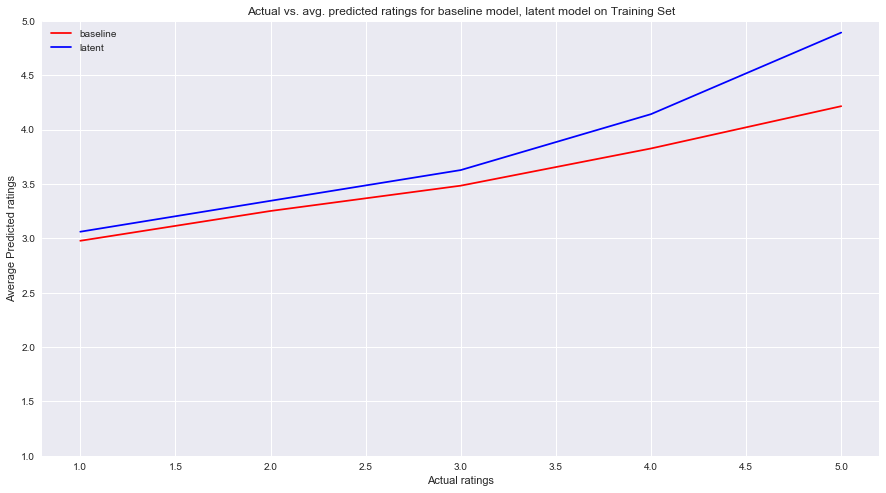

In [304]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], pred_avg, color='red', label = 'baseline')
ax.plot([1, 2, 3, 4, 5], pred_avg_latent, color='blue', label = 'latent')
ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, latent model on Training Set')
ax.set_ylim((1,5))
ax.legend();

In [306]:
test_pred_avg = []
test_pred_avg_latent = []
for i in [1, 2, 3, 4, 5]:
    test_pred_avg.append(test_df_v2[test_df_v2['stars'] == i]['pred_base'].mean())
    test_pred_avg_latent.append(test_df_v2[test_df_v2['stars'] == i]['pred_latent'].mean())

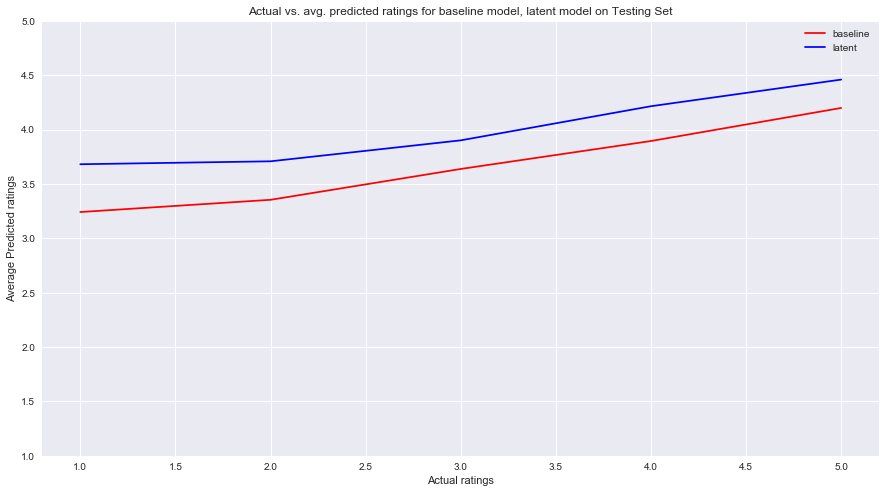

In [307]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.plot([1, 2, 3, 4, 5], test_pred_avg, color='red', label = 'baseline')
ax.plot([1, 2, 3, 4, 5], test_pred_avg_latent, color='blue', label = 'latent')
ax.set_xlabel('Actual ratings')
ax.set_ylabel('Average Predicted ratings')
ax.set_title('Actual vs. avg. predicted ratings for baseline model, latent model on Testing Set')
ax.set_ylim((1,5))
ax.legend();

### Latent factors overestimate

As you can see, our latent factors overestimate compared the baseline. This is becase we only tuned using positive values, which assumed that all the residuals are positive. However, this is a false assumption as some residuals are negative. If we had the computational resources, we would have the values in our tuning vector range beteen (-1, 1). 